1544 1532
(1639.203266938072, 1639.0, 42.604828019589505)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(1638.3561393253337, 1638.0, 41.44739112108312)
[('id', '<i8'), ('xcentroid', '<f8'), ('ycentroid', '<f8'), ('fwhm', '<f8'), ('sharpness', '<f8'), ('roundness', '<f8'), ('pa', '<f8'), ('npix', '<i8'), ('sky', '<f8'), ('peak', '<f8'), ('flux', '<f8'), ('mag', '<f8')]
[[3.70786945e+02 1.94911605e+00]
 [4.59030389e+02 1.94593640e+00]
 [1.97778708e+03 2.12605791e+00]
 ...
 [6.63847069e+02 1.99202177e+03]
 [1.37334340e+03 1.99220359e+03]
 [1.05887338e+03 1.99620336e+03]]
 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 370.78694  1.949116    690265.87
  2 459.03039 1.9459364     696742.9
  3 1977.7871 2.126057

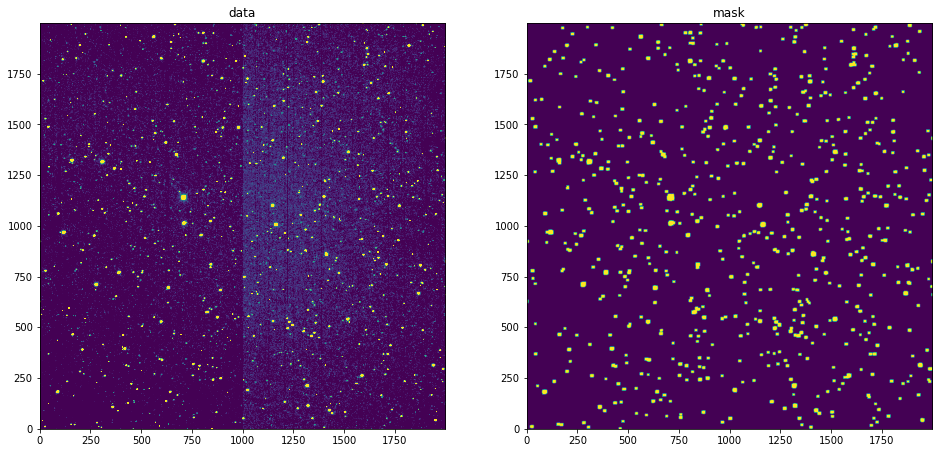

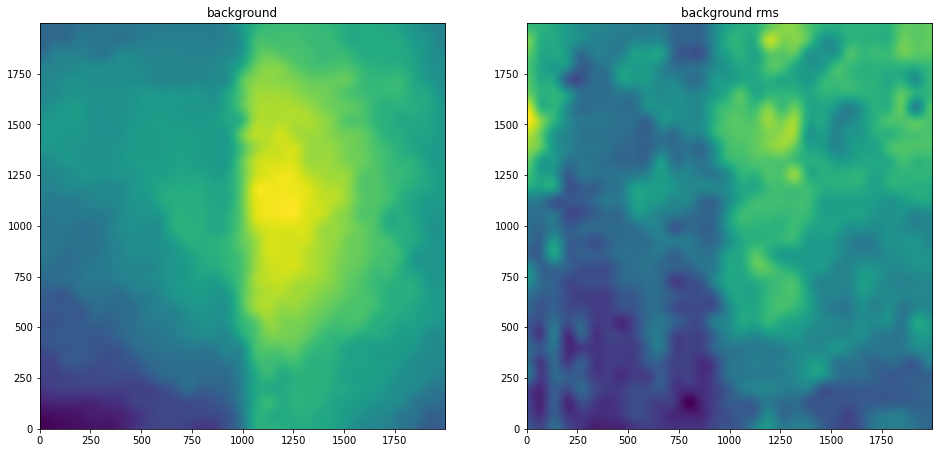

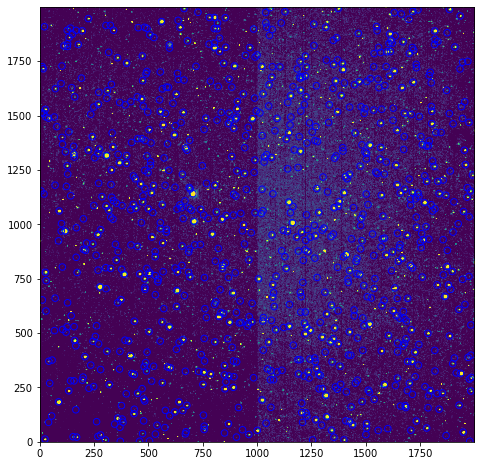

In [1]:
from astropy.io import fits
from matplotlib import pyplot as plt
from astropy.stats import sigma_clipped_stats,SigmaClip, mad_std
import numpy as np
import sys, os, glob
from datetime import datetime
import photutils as pht
from photutils.aperture import aperture_photometry, CircularAperture

start = datetime.now()
data_path='/media/zhang/200A1A7B0A1A4E62/y50/'
obs_date='20211221_test'

#[l,r]
gain_50b=[0.68,0.60]  
gain_50a=[0.58,0.57] 

allfiles=[]
im_obsdate=[]

#import the fit header
allfiles=glob.glob(data_path+obs_date+'/*fit')
allfiles=np.array(allfiles)
for i,ifile in enumerate(allfiles):
    #print("reading header of fit:", i+1,len(allfiles),ifile)
    tem_header  = fits.getheader(ifile)    
    tem_obsdate = tem_header['DATE-OBS'] 
    im_obsdate.append(tem_obsdate)

#sort the time
obsdate_latest=sorted(im_obsdate,reverse=True)
index_latest=np.where(np.array(im_obsdate) == obsdate_latest[0])
new_image=fits.getdata(allfiles[index_latest[0][0]])
new_header=fits.getheader(allfiles[index_latest[0][0]])
#get imformation of the fit header
new_stype=new_header['IMAGETYP'] 
new_object=new_header['OBJECT'] 
new_objectra=new_header['OBJCTRA'] 
new_objectdec=new_header['OBJCTDEC']
new_obsdate=  new_header['DATE-OBS']
new_exptime  = new_header['EXPTIME']
#trim image
xy=[1,np.size(new_image,0),500,np.size(new_image,1)-500]      
new_image=new_image[xy[0]:xy[1],xy[2]:xy[3]]
y_cen=round(np.size(new_image,0)/2.)
x_cen=round(np.size(new_image,1)/2.) 
print(x_cen,y_cen)
def show_image(new_image):
        #trim the data
        tmpdata_l=new_image[y_cen-400:y_cen+400,x_cen-900:x_cen-100]
        tmpdata_r=new_image[y_cen-400:y_cen+400,x_cen+100:x_cen+900]        
        mean_l, median_l, stdev_l = sigma_clipped_stats(tmpdata_l, sigma=3,maxiters=2)
        mean_r, median_r, stdev_r = sigma_clipped_stats(tmpdata_r, sigma=3,maxiters=2)
        
        # show the image
        fig=plt.figure(figsize=(16,8))
        # Here we set xmin, ymin, width, and height to 0.05, 0.05, 0.5, 0.95 respectively.
        ax0 =fig.add_axes([0.05,0.05,0.5,0.95])      
        ish=ax0.imshow(new_image/np.median([tmpdata_r,tmpdata_l]),vmin=0.95,vmax=1.03,origin='lower',interpolation ='nearest') #
        colorbar_ax = fig.add_axes([0.56, 0.1, 0.01, 0.85])
        plt.colorbar(ish,ax=ax0,cax=colorbar_ax,shrink=.6)

        #show the background y_cen
        x1 = [x for x in range(0, np.size(new_image,1))]
        ax1 =fig.add_axes([0.67,0.83,0.30,0.12])
        y1=new_image[round(np.size(new_image,0)/2.),:]
        y1=np.clip(y1,a_min=np.median(y1)-3.*np.std(y1),a_max=np.median(y1)+3.*np.std(y1))
        y1=np.clip(y1,a_min=np.median(y1)-3.*np.std(y1),a_max=np.median(y1)+3.*np.std(y1))
        ax1.plot(x1,y1)
        ax1.set_xticks([])
        ax1.set_ylabel('Y$_{cen}$',fontsize =15)
        
        #show the background L_cen
        x2 = [x for x in range(0, np.size(new_image,0))]
        ax2 =fig.add_axes([0.67,0.71,0.30,0.12])
        y2=new_image[:,round(np.size(new_image,1)/4.)]
        y2=np.clip(y2,a_min=np.median(y2)-3.*np.std(y2),a_max=np.median(y2)+3.*np.std(y2))
        y2=np.clip(y2,a_min=np.median(y2)-3.*np.std(y2),a_max=np.median(y2)+3.*np.std(y2))
        ax2.plot(x2,y2)
        ax2.set_xticks([])
        ax2.set_ylabel('L$_{cen}$',fontsize =15)
        
        #show the background R_cen
        x3 = [x for x in range(0, np.size(new_image,0))]
        ax3 =fig.add_axes([0.67,0.59,0.30,0.12])   
        y3=new_image[:,round(np.size(new_image,1)*3./4.)]
        y3=np.clip(y3,a_min=np.median(y3)-3.*np.std(y3),a_max=np.median(y3)+3.*np.std(y3))
        y3=np.clip(y3,a_min=np.median(y3)-3.*np.std(y3),a_max=np.median(y3)+3.*np.std(y3))
        ax3.plot(x3,y3)
        ax3.set_ylabel('R$_{cen}$',fontsize =15)
        
        #show the background R_cen
        plt.figtext(0.66,0.50,'File = '+os.path.basename(allfiles[index_latest[0][0]]),fontsize=15)
        plt.figtext(0.66,0.45,'Object = ' + new_object,fontsize=15)
        plt.figtext(0.86,0.45,'Exptime = ' + str('%.f' %new_exptime),fontsize=15)  
        plt.figtext(0.66,0.40,'Time = ' + new_obsdate,fontsize=15)  
        plt.figtext(0.88,0.40,'Index = ' + str(index_latest[0][0]),fontsize=15)  
        plt.figtext(0.66,0.35,'RA = '  + new_objectra ,fontsize=15)  
        plt.figtext(0.85,0.35,'DEC = ' + new_objectdec,fontsize=15)  
        plt.figtext(0.66,0.30,'median_l = ' + '%.1f' %median_l,fontsize=15)  
        plt.figtext(0.85,0.30,'median_r = ' + '%.1f' %median_r,fontsize=15)
        plt.figtext(0.66,0.25,'mean_l = ' + '%.1f' %mean_l,fontsize=15)  
        plt.figtext(0.85,0.25,'mean_r = ' + '%.1f' %mean_r,fontsize=15)
        plt.figtext(0.66,0.20,'stdev_l = ' + '%.1f' %stdev_l,fontsize=15)  
        plt.figtext(0.85,0.20,'stdev_r = ' + '%.1f' %stdev_r,fontsize=15)  
        
        return
#------------------------------------------------------------------------------------------------------------


tmpdata=new_image[y_cen-1000:y_cen+1000,x_cen-1000:x_cen+1000]

mean, median, std = sigma_clipped_stats(tmpdata, sigma=3.0,maxiters=2)
print((mean, median, std))
    
    

f,axs=plt.subplots(1,2,figsize=(16,8))
axs[0].imshow(tmpdata,vmin=median,vmax=median+3*std,origin='lower')
axs[0].set_title("data")
## or first mask sources then estimate the sky background
mask = pht.make_source_mask(tmpdata, nsigma=3, npixels=5, dilate_size=11)
mean, median, std = sigma_clipped_stats(tmpdata, sigma=3.0, mask=mask)
print((mean, median, std))
axs[1].imshow(mask,origin='lower')
axs[1].set_title("mask")


sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = pht.SExtractorBackground()
bkg = pht.Background2D(tmpdata, (64, 64), mask=mask,filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)


f,axs=plt.subplots(1,2,figsize=(16,8))
axs[0].imshow(bkg.background,origin='lower')
axs[0].set_title("background")
axs[1].imshow(bkg.background_rms,origin='lower')
axs[1].set_title("background rms")

## find objects and calculate basic information
daofind = pht.IRAFStarFinder(fwhm=3.0, threshold=6.*bkg.background_rms_median, 
                             exclude_border=True, sharplo=0.5, sharphi=2.0, roundlo=0.0, roundhi=0.7)

sources = daofind(tmpdata - bkg.background_median)

print(sources.dtype)


fig=plt.figure(figsize=(16,8))
plt.imshow(tmpdata,vmin=median,vmax=median+3*std,origin='lower')



positions = np.transpose((sources['xcentroid'], sources['ycentroid'])) 
print(positions)
apertures = CircularAperture(positions, r=15.)  
phot_table = aperture_photometry(tmpdata, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)
apertures.plot(color='blue')
#print(phot_table)

if   (new_stype == 'Light Frame'):  
    print('show '+ new_stype)    
    
    
    
else: 
    print('show '+ new_stype)  
    show_image(new_image) 

#head=fits.getheader()

plt.savefig('/media/zhang/200A1A7B0A1A4E62/y50/test.eps', format='eps')
end = datetime.now()
print("The time of execution of above program is :", str(end-start)[5:10],'s')

 